In [1]:
## mount the Google drive to get access to files in your drive ##
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
#%cd /content/drive/MyDrive/Colab Notebooks

In [3]:
## in case you need to upgrade sklearn

#!pip install --upgrade scikit-learn #

In [4]:
## in case you need to upgrade statsmodels

#! pip uninstall statsmodels
#! pip install statsmodels

In [5]:
## import libraries and tools ##

import numpy as np # linear algebra
import pandas as pd # data processing and CSV file I/O

import scipy as sp # scientific and technical computing
from scipy import stats

import math

#from matplotlib import rcParams
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization

# we primarily use sklearn in this model
import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, ElasticNetCV

# we will use statsmodels for ordinal logistic regression
import statsmodels as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

import missingno  # missing data visualization

# Review and Understand the Dataset

Concrete compressive strength can be predicted by concrete attributes. In the following, we list the name, type, measurement unit, and a brief description, of concrete attributes and concrete compressive strength.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable
- Water -- quantitative -- kg in a m3 mixture -- Input Variable
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable
- Age -- quantitative -- Day (1~365) -- Input Variable
- Concrete compressive strength -- quantitative -- MPa -- Output Variable
- Defect -- binary -- 1/0 -- Output Variable

In [6]:
## read the dataset in csv format ##
df = pd.read_csv('Data/Concrete_Data.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
 9   dft               1030 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 80.6 KB
None


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa,dft
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0


In [7]:
## change the name of column "csMpa" to "strength" and return a new dataset
df.rename(columns={'csMPa': 'strength'}, inplace=True)
print(df.shape)
df.head()

(1030, 10)


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,strength,dft
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0


In [8]:
## count missing values
df.isnull().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
strength            0
dft                 0
dtype: int64

# Splitting dataset into training data and test data

In [9]:
# separate the attribute data X from the response data y
X = df.iloc[:,:-2] # all columns except for the last two columns
Y = df.iloc[:,-2:] # the last two columns are the response variables

In [10]:
## split the dataset into training and testing datasets using a 80%-20% randomized split.##
## train_test_split (X, y, test_size, random_state) in sklearn can be used for this purpose##
random_state = 15 # select a specific random_state to ensure the result is reproducable
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state=random_state
                                                   )

In [11]:
# dimension of the training dataset
X_train.shape, Y_train.shape

((824, 8), (824, 2))

In [12]:
# dimension of the test dataset
X_test.shape, Y_test.shape

((206, 8), (206, 2))

# Feature Selection

## Are raw attributes correlated?

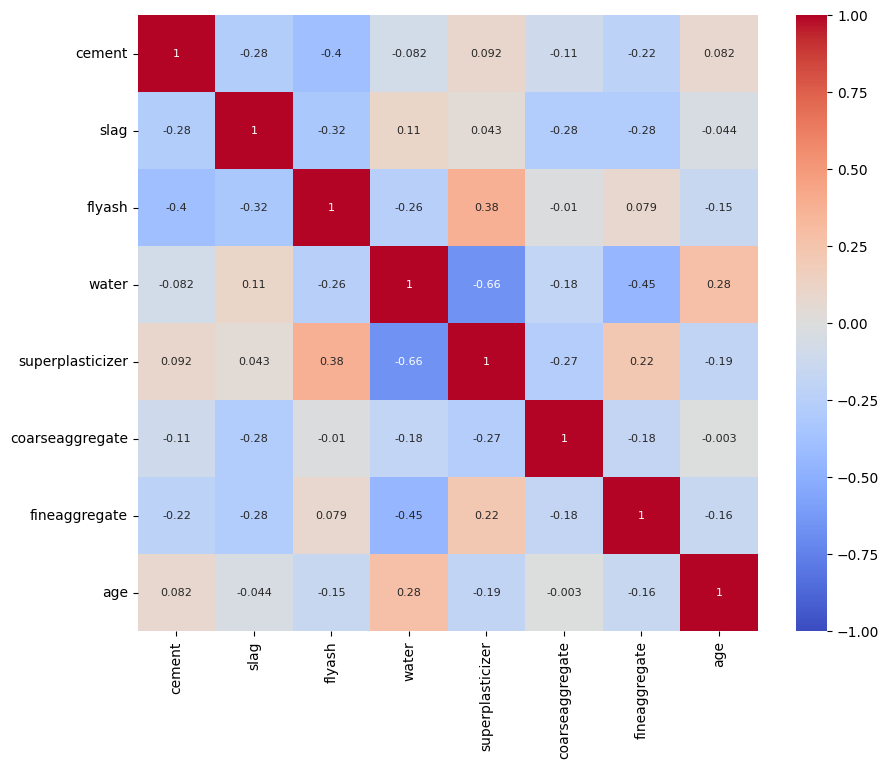

In [13]:
## Visualize the correlation between any two columns as heatmap.
# What do you see from the correlation heatmap? If several attributes have strong correlation, colinearity could be an issue for the regression analysis

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(X.corr(), annot = True, annot_kws={'size':8}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax);

## How many features to extract/select ?

In [14]:
# nromalize feature data using StandardScaler() and fit_transform() from sklearn
X_norm=StandardScaler().fit_transform(X)

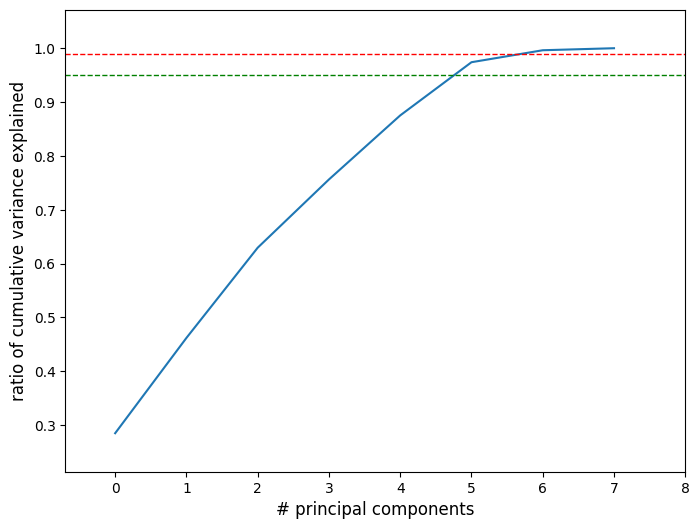

In [15]:
# PCA analysis
plt.figure(figsize=(8,6))
pca_dummy = PCA()
pca_dummy.fit(X_norm)
plt.plot(np.cumsum(pca_dummy.explained_variance_ratio_))
plt.axhline(y = 0.99, c='r', linewidth =1, linestyle='--')
plt.axhline(y = 0.95, c='g', linewidth =1, linestyle='--' )
plt.margins(0.1)
plt.xticks(range(9))
plt.xlabel('# principal components',fontsize=12)
plt.ylabel('ratio of cumulative variance explained',fontsize=12)
plt.show()

## Extract Features using PCA

In [16]:
# nromalize attributes data
X_train_norm = StandardScaler().fit_transform(X_train)
X_test_norm = StandardScaler().fit_transform(X_test)

In [17]:
# apply PCA to transform feature data into their principal components
pca= PCA()
pca.fit(X_train_norm) # determine the PCA projection matrix using the training data
X_train_tsf=pca.transform(X_train_norm) # transform the training data as PCs
X_test_tsf=pca.transform(X_test_norm) # transform the testing data as PCs

## Exploratory Data Analysis

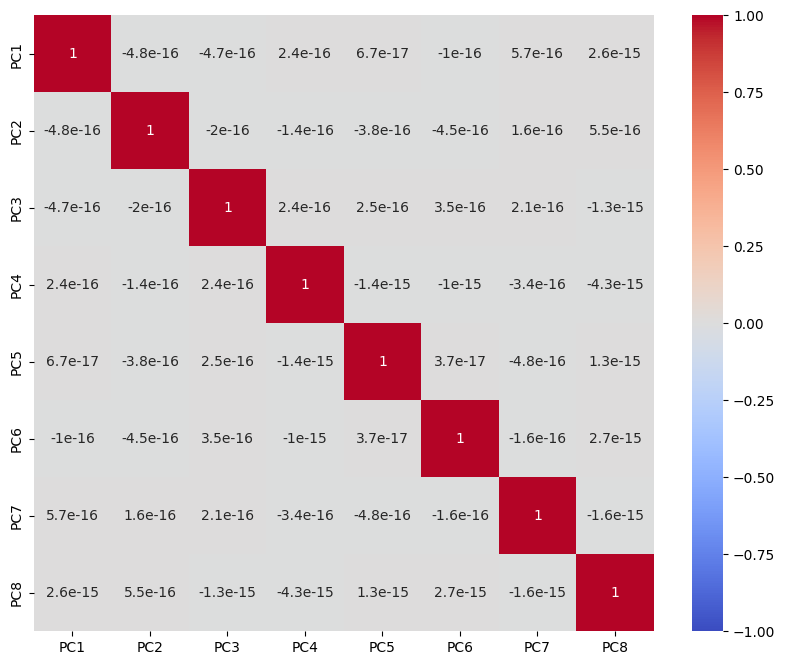

In [18]:
# visualize the correltion of transformed training data
fig, ax = plt.subplots(figsize=(10,8))
xticklabels=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']
yticklabels=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']
sns.heatmap(np.corrcoef(X_train_tsf.T),annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', ax=ax, xticklabels=xticklabels,yticklabels=yticklabels)

plt.show()

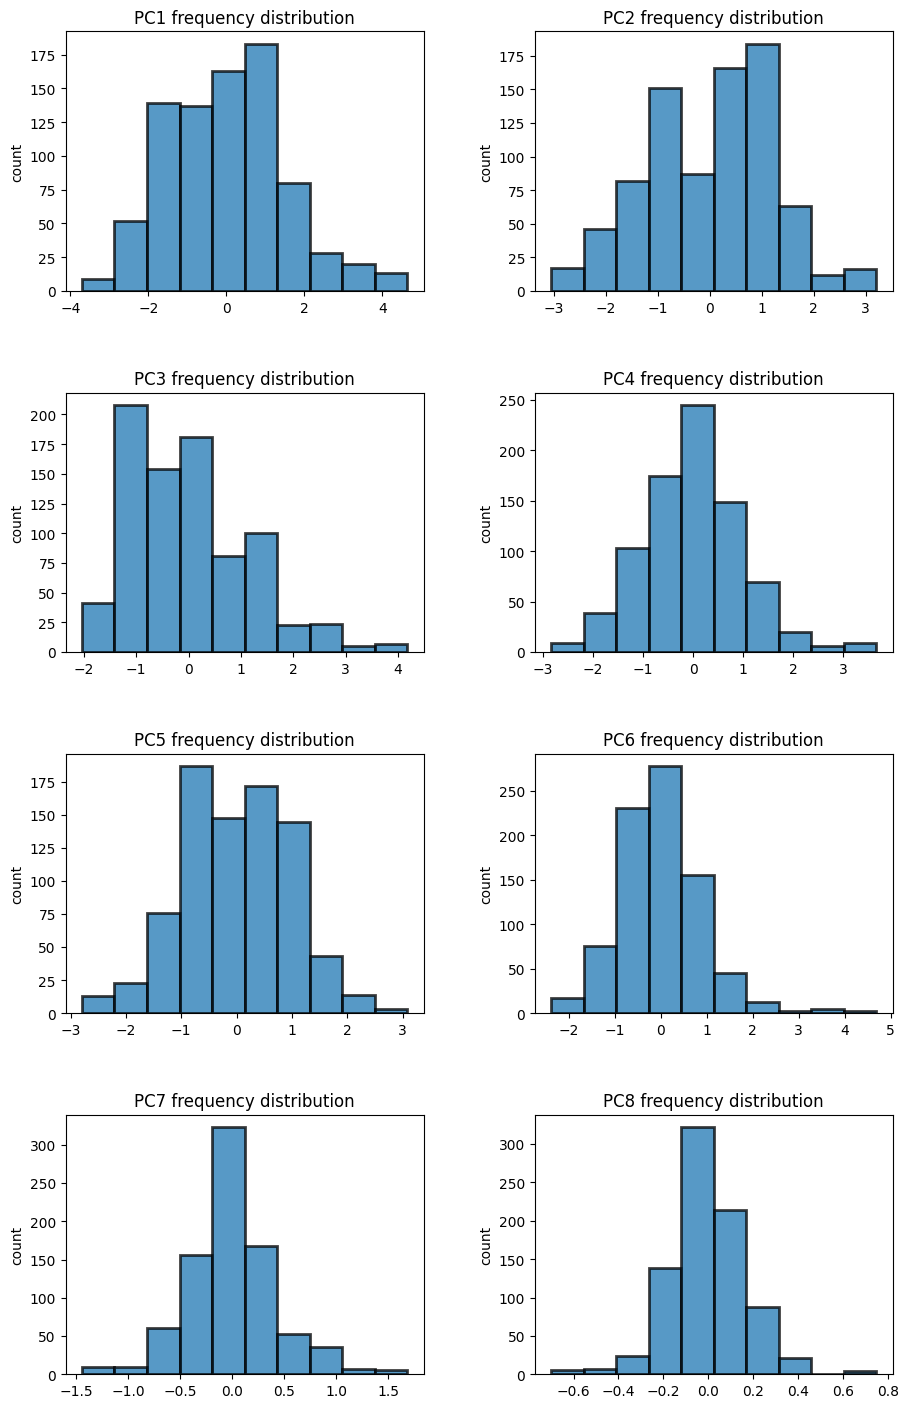

In [19]:
# frequency distributions of PC features
plt.figure(figsize=(10,15))
for i in range(0,8):
  plt.subplot(4,2,(i)+1)
  plt.hist(x=X_train_tsf[:,i],alpha=0.75,edgecolor='black',linewidth=2)
  plt.title('PC'f'{i+1} frequency distribution',fontsize=12)
  plt.ylabel('count')
  plt.tight_layout(pad=4.0)
  plt.grid(False)



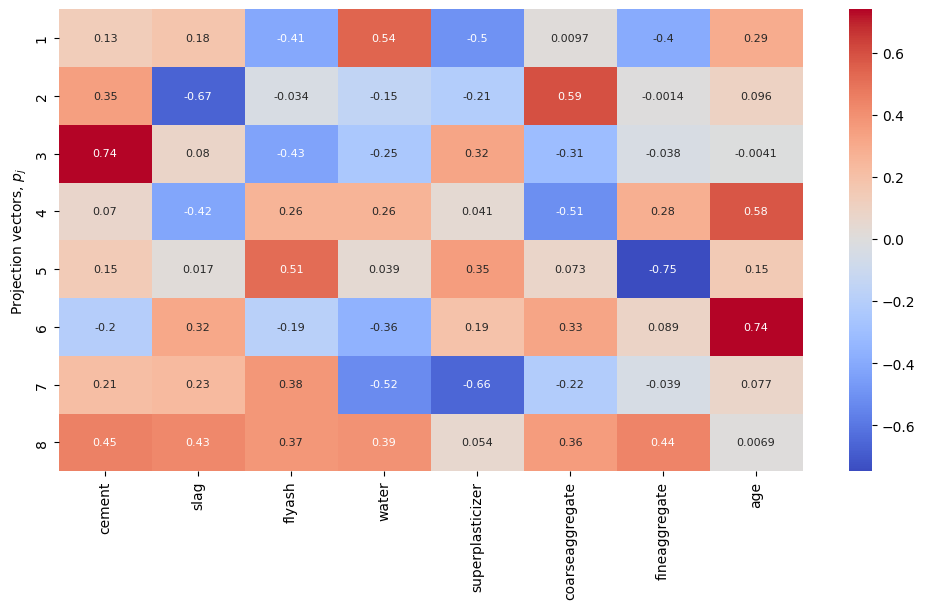

In [20]:
# the correlation between the PC features and the raw features
rel= pd.DataFrame(pca.components_,columns=df.columns[0:-2])
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(rel,cmap='coolwarm',annot=True,annot_kws={'size':8})
ax.set_yticklabels(np.arange(1,9,1))
plt.ylabel('Projection vectors, $p_j$')
plt.show()

# Define metrics for evaluating goodness-of-fit

In [21]:
# assembly model evaluation metrics together
def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    #return mae, mse, rmse, r2_square
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'R Square: {r2_square:.3f}')
    print('__________________________________')


# Training and Test Data for Regression Modeling

In [22]:
# the training and test data of predictors are the PCs. Origional attributes of concrete can be used as well.
X_st_train = X_train_tsf
X_st_test = X_test_tsf

In [23]:
# the quantity response is the strength measurement, which is the first column in Y
y_st_train = Y_train.values[:,0]
y_st_test = Y_test.values[:,0]

In [24]:
# the categorical response is defect class, which is the second comlumn in Y
y_dft_train = Y_train.values[:,-1]
y_dft_test =Y_test.values[:,-1]

# Linear Regression Model

## Ordinary Least Squares

In [25]:
# call the linear regressor
lr = LinearRegression()

# fit the linear regression model
lr_model = lr.fit(X_st_train,y_st_train)

In [26]:
# regression coefficients, w0, w1,..., w8
coeff_df = pd.DataFrame(np.append(lr_model.intercept_,lr_model.coef_), ['INT', 'PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'], columns=['Coefficient'])
coeff_df.round(4)

,Coefficient
INT,35.7782
PC1,-0.0214
PC2,-0.1117
PC3,8.5483
PC4,1.8100
PC5,5.2646
PC6,6.8206
PC7,7.9216
PC8,11.6399


In [27]:
## You can also find regression coefficients using linear algebra
Z_train = np.append(np.ones([len(X_st_train),1]),X_st_train,1)
w_hat = np.linalg.inv(Z_train.T @ Z_train) @ Z_train.T @ y_st_train
coef_lr = pd.DataFrame(w_hat,index=['INT','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],columns=['Coefficient'])
coef_lr.round(4)

,Coefficient
INT,35.7782
PC1,-0.0214
PC2,-0.1117
PC3,8.5483
PC4,1.8100
PC5,5.2646
PC6,6.8206
PC7,7.9216
PC8,11.6399


In [28]:
# calculate standard errors of regression efficients using linear algebra
m = X_st_train.shape[0]
n = X_st_train.shape[1]
residuals = y_st_train - lr_model.predict(X_st_train)
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (m-n-1) # this is the point estimate of sigma_epsilon^2

var_w_hat =np.linalg.inv(Z_train.T @ Z_train)*sigma_squared_hat

for i in range(n+1):
  standard_error = var_w_hat[i, i] ** 0.5
  print(f"standard error(w_hat[{i}]): {standard_error:.3f}")


standard error(w_hat[0]): 0.360
standard error(w_hat[1]): 0.239
standard error(w_hat[2]): 0.301
standard error(w_hat[3]): 0.315
standard error(w_hat[4]): 0.360
standard error(w_hat[5]): 0.365
standard error(w_hat[6]): 0.404
standard error(w_hat[7]): 0.855
standard error(w_hat[8]): 2.094


In [29]:
# margin of error for regression coefficients. The (1-alpha) confidence interval estimate is point estimate +/- margin of error
from scipy.stats import t
alpha = 0.05 # level of significance. You can change to your own value
t_val = t(m-n-1).ppf(1-alpha/2) # t-value at 1-alpha/2
me = np.empty(9)
for i in range(n+1):
  me[i]=var_w_hat[i, i] ** 0.5*t_val
  print(f'margin of error[w_hat[{i}]:{me[i]:.3f}')

margin of error[w_hat[0]:0.707
margin of error[w_hat[1]:0.469
margin of error[w_hat[2]:0.591
margin of error[w_hat[3]:0.618
margin of error[w_hat[4]:0.706
margin of error[w_hat[5]:0.716
margin of error[w_hat[6]:0.793
margin of error[w_hat[7]:1.678
margin of error[w_hat[8]:4.110


In [30]:
# display the (1-alpha) confidence interval estimates for regression coefficients w0, w1,..., w8
lr_coefficients_CI=pd.DataFrame(np.append(w_hat.reshape(9,1),me.reshape(9,1),1),
                                index=['INT','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],
                                columns=['Coefficients','Margin of error'])
print(f'the {1-alpha} confidence interval for regression coefficients are:\n')
lr_coefficients_CI.round(3)

the 0.95 confidence interval for regression coefficients are:



,Coefficients,Margin of error
INT,35.778,0.707
PC1,-0.021,0.469
PC2,-0.112,0.591
PC3,8.548,0.618
PC4,1.810,0.706
PC5,5.265,0.716
PC6,6.821,0.793
PC7,7.922,1.678
PC8,11.640,4.110


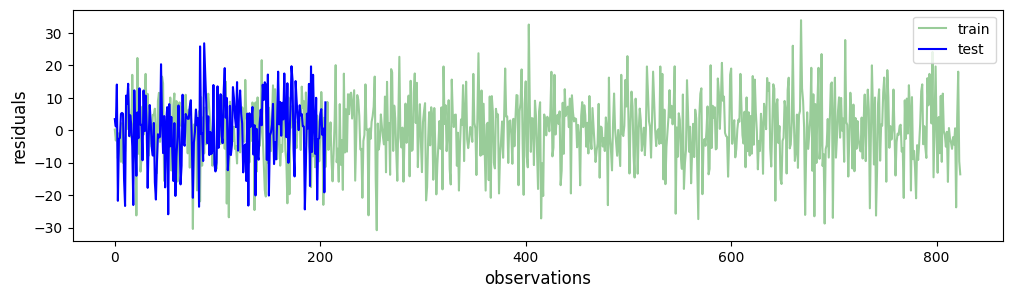

In [31]:
# visually check independence of residuals
plt.figure(figsize=(12,3))
plt.plot(y_st_train-lr_model.predict(X_st_train),c='g',alpha=0.4) # residual calculated using the training dataset
plt.plot(y_st_test-lr_model.predict(X_st_test),c='b') # residual calculated using the testing dataset
plt.xlabel('observations',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.legend(['train','test'])
plt.show()

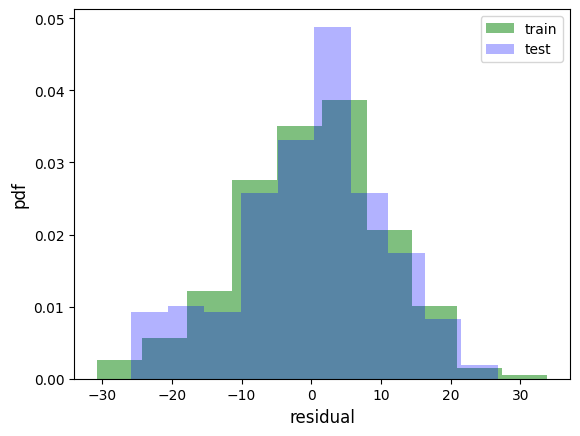

In [32]:
# examine the distribution of residuals
plt.hist(y_st_train-lr_model.predict(X_st_train),density=True,color='g',alpha=0.5) # distribution of residuals - training dataset
plt.hist(y_st_test-lr_model.predict(X_st_test),density=True,color='b',alpha=0.3) # distribuition of residuals - testing dataset
plt.legend(['train','test'])
plt.xlabel('residual',fontsize=12)
plt.ylabel('pdf',fontsize=12)
plt.show()

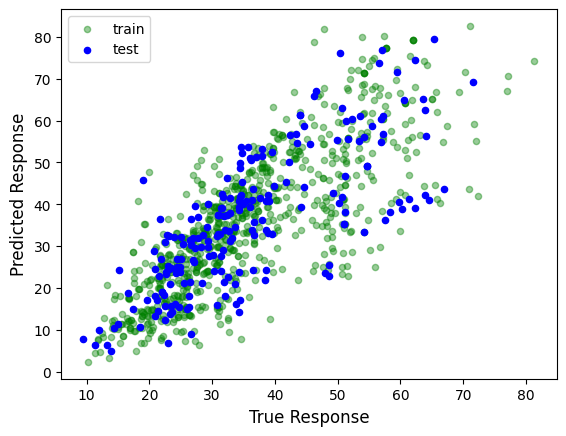

In [33]:
# show the correlation between predicted response and true response
plt.scatter(lr_model.predict(X_st_train),y_st_train,c='g',s=20,alpha=0.4) # true vs. prediction - training dataset
plt.scatter(lr_model.predict(X_st_test),y_st_test,c='b',s=20) # # true vs. prediction - testing dataset
plt.xlabel('True Response',fontsize=12)
plt.ylabel('Predicted Response',fontsize=12)
plt.legend(['train','test'])
plt.show()

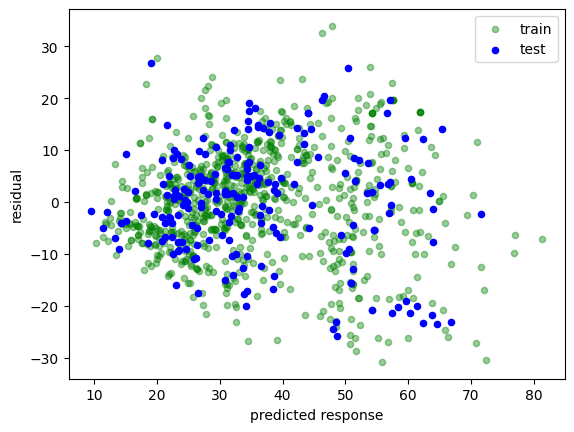

In [34]:
# residual against predicted response to check the homogeneity of residuals
plt.scatter(lr_model.predict(X_st_train), y_st_train-lr_model.predict(X_st_train),c='g',s=20,alpha=0.4)  # residual vs. prediction - training dataset
plt.scatter(lr_model.predict(X_st_test), y_st_test-lr_model.predict(X_st_test),c='b',s=20) # residual vs. prediction -testing dataset
plt.legend(['train','test'])
plt.xlabel('predicted response')
plt.ylabel('residual')
plt.show()

In [35]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(lr, X_st_train, y_st_train, cv =5, scoring = 'r2').mean()
print(f'the average r-squared value is {r2_train*100 :.2f}%')

the average r-squared value is 60.51%


In [36]:
# calculate Log likelihood, AIC, and BIC
# log-likelihood of regression (let's check if our calculation is correct)
m = X_st_train.shape[0] # the number of observations
n= X_st_train.shape[1] # the number of predictor variables
LogL = (-m/2*np.log(2*np.pi)-m*np.log(np.sqrt(metrics.mean_squared_error(y_st_train, lr_model.predict(X_st_train))))-(m-n-1)/2).round(0)
print(f"Maximum Log Likelihood is {LogL:.0f}")

# calcualte AIC and BIC
AIC = -2*LogL+2*(1+n)
BIC = -2*LogL+np.log(m)*(1+n)

print(f"AIC is:{AIC:.0f}")
print(f"BIC is:{BIC:.0f}")



Maximum Log Likelihood is -3085
AIC is:6188
BIC is:6230


In [37]:
# evaluate the model on the testing dataset
print_evaluate(y_st_test, lr_model.predict(X_st_test))

MAE: 8.339
MSE: 111.127
RMSE: 10.542
R Square: 0.569
__________________________________


In [38]:
# Univariate feature selection works by selecting the best features based
# on univariate statistical tests. It can be seen as a preprocessing step to
#an estimator.
# SelectBest (metric, k) selects features according to the k highest scores.
FeatureSelection = SelectKBest(f_regression, k=6)
X_st_train_new=FeatureSelection.fit_transform(X_st_train, y_st_train)
SelectedFeatures=FeatureSelection.get_support()
print('Selected features are:\n',SelectedFeatures,'\n')

lr_new=LinearRegression()
lr_model_new = lr_new.fit(X_st_train_new, y_st_train)

X_st_test_new = pd.DataFrame(X_st_test,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
X_st_test_new = X_st_test_new.loc[:,SelectedFeatures].values

# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(lr_new, X_st_train_new, y_st_train, cv =5, scoring = 'r2').mean()
print(f'the average r-squared value is {r2_train*100 :.2f}%\n')

# log-likelihood of regression
m = X_st_train_new.shape[0] # the number of observations
n= X_st_train_new.shape[1] # the number of predictor variables
LogL = (-m/2*np.log(2*np.pi)-m*np.log(np.sqrt(metrics.mean_squared_error(y_st_train, lr_model_new.predict(X_st_train_new))))-(m-n-1)/2).round(0)
print(f"Maximum Log Likelihood is {LogL:.0f}")

# calcualte AIC and BIC
AIC = -2*LogL+2*(1+n)
BIC = -2*LogL+np.log(m)*(1+n)

print(f"AIC is:{AIC:.0f}")
print(f"BIC is:{BIC:.0f}")

print('\nThe test accuracy is:')
print_evaluate(y_st_test, lr_model_new.predict(X_st_test_new))

Selected features are:
 [False False  True  True  True  True  True  True] 

the average r-squared value is 60.82%

Maximum Log Likelihood is -3087
AIC is:6188
BIC is:6221

The test accuracy is:
MAE: 8.342
MSE: 111.400
RMSE: 10.555
R Square: 0.568
__________________________________


## Laccos

In [39]:
# fit a Lasso regression model
lassor = Lasso(alpha=0.2)
lassor_model = lassor.fit(X_st_train,y_st_train)

In [40]:
# regression coefficents
coeff_lassor = pd.DataFrame(np.append(lassor_model.intercept_,lassor_model.coef_),
                            ['INT', 'PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],
                            columns=['Coefficient'])
coeff_lassor.round(4)

,Coefficient
INT,35.7782
PC1,-0.0000
PC2,-0.0000
PC3,8.3956
PC4,1.6108
PC5,5.0597
PC6,6.5693
PC7,6.7962
PC8,4.8869


In [41]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(lassor, X_st_train, y_st_train, cv =5, scoring = 'r2').mean()
print(f'the average r-squared value is {r2_train*100 :.2f}%')

the average r-squared value is 59.94%


In [42]:
# evaluate the model on the test dataset
print_evaluate(y_st_test, lassor_model.predict(X_st_test))

MAE: 8.469
MSE: 111.065
RMSE: 10.539
R Square: 0.569
__________________________________


## Ridge

In [43]:
# fit a Ridge regression model
rr = Ridge(alpha=20)
rr_model = rr.fit(X_st_train,y_st_train)


In [44]:
# regression coefficents
coeff_Ridge = pd.DataFrame(np.append(rr_model.intercept_,rr_model.coef_), ['INT', 'PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'], columns=['Coefficient'])
coeff_Ridge.round(4)

,Coefficient
INT,35.7782
PC1,-0.0212
PC2,-0.1098
PC3,8.3927
PC4,1.7673
PC5,5.1368
PC6,6.6187
PC7,6.9697
PC8,6.3972


In [45]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(rr, X_st_train, y_st_train, cv =5, scoring = 'r2').mean()
print(f'the average r-squared value is {r2_train*100 :.2f}%')

the average r-squared value is 60.12%


In [46]:
# evaluate the model on the test dataset
print_evaluate(y_st_test, rr_model.predict(X_st_test))

MAE: 8.424
MSE: 110.593
RMSE: 10.516
R Square: 0.571
__________________________________


## Elastic Net

In [47]:
# fit Elastic Net regression that combines both L1 and L2 regulations on
# regression coefficients

#For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1
# penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2
enr = ElasticNet(alpha=0.2,l1_ratio=1)
enr_model = enr.fit(X_st_train,y_st_train)

In [48]:
# regression coefficents
coeff_enr = pd.DataFrame(np.append(enr_model.intercept_,enr_model.coef_), ['INT', 'PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'], columns=['Coefficient'])
coeff_enr.round(4)

,Coefficient
INT,35.7782
PC1,-0.0000
PC2,-0.0000
PC3,8.3956
PC4,1.6108
PC5,5.0597
PC6,6.5693
PC7,6.7962
PC8,4.8869


In [49]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(enr, X_st_train, y_st_train, cv =5, scoring = 'r2').mean()
print(f'the average r-squared value is {r2_train*100 :.2f}%')

the average r-squared value is 59.94%


In [50]:
# evaluate the model on the test dataset
print_evaluate(y_st_test, enr_model.predict(X_st_test))

MAE: 8.469
MSE: 111.065
RMSE: 10.539
R Square: 0.569
__________________________________


## Fine tuning Hyperparameters of Elastic Net Regression

In [51]:
# fit Elastic Net regression that combines both L1 and L2 regulations on
# regression coefficients

# This
# parameter can be a list, in which case the different values are tested by
# cross-validation and the one giving the best prediction score is used.

# Note that a good choice of list of values for l1_ratio is often to put more values
# close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge), as in
 # [.1, .5, .7, .9, .95, .99, 0.995, 1].
l1_ratios = [.1, .5, .7, .9, .95, .99, .995, 1]

# we either choose a list of alpha or define the number of alphas for each l1 reatio
#alphas = np.arange(0,10.,0.1)

encvr = ElasticNetCV(l1_ratio=l1_ratios,cv=5,random_state=5,n_alphas=100)
encvr_model = encvr.fit(X_st_train,y_st_train)
print('The selected alpha is', f'{encvr_model.alpha_:.3}','\n')
print('The selected l1 ratio is', f'{encvr_model.l1_ratio_:.3}','\n')

#print_evaluate(y_st_test, encvr_model.predict(X_st_test))

The selected alpha is 0.0124 

The selected l1 ratio is 0.9 



In [52]:
# regression coefficents
coeff_encvr = pd.DataFrame(np.append(encvr_model.intercept_,encvr_model.coef_), ['INT', 'PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'], columns=['Coefficient'])
coeff_encvr.round(4)

,Coefficient
INT,35.7782
PC1,-0.0165
PC2,-0.1038
PC3,8.5317
PC4,1.7966
PC5,5.2464
PC6,6.7959
PC7,7.8040
PC8,10.8082


In [53]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(encvr, X_st_train, y_st_train, cv =5, scoring = 'r2').mean()
print(f'the average r-squared value is {r2_train*100 :.2f}%')

the average r-squared value is 60.45%


In [54]:
# evaluate the model on the test dataset
print_evaluate(y_st_test, encvr_model.predict(X_st_test))

MAE: 8.351
MSE: 110.954
RMSE: 10.533
R Square: 0.569
__________________________________


# Polynomial Linear Model

## Generate polynomial features from predictor variables

In [55]:
# generate polynomial features
poly_degree = 3
poly_reg = PolynomialFeatures(degree=poly_degree) # if a, b and c are three features, ab, ac, and bc are degree-2 polynomial features. a^2b, a^2c, b^2a, b^2c, c^2a, c^2b, a^3, b^3, c^3 are 3-degree polynomial features
X_poly_train= poly_reg.fit_transform(X_train_tsf) # transform features into those with polynomial features
X_poly_test=poly_reg.fit_transform(X_test_tsf)

## Fine tune Elastic Net

In [56]:
l1_ratios = [.1, .5, .7, .9, .95, .99, .995, 1]

plr=ElasticNetCV(l1_ratio=l1_ratios,cv=5,random_state=5,n_alphas=100, max_iter=2000, tol=0.01, fit_intercept=False)
plr_model=plr.fit(X_poly_train,y_st_train)

print('The selected alpha is', f'{plr_model.alpha_:.3}','\n')
print('The selected l1 ratio is', f'{plr_model.l1_ratio_:.3}','\n')
## result of fine tuning suggests the best model is Laccos regression, that is linear regression with norm-1 regularization

## If we remove the regulilarizers, we just use the ordinary linear regrsesion model
#plr_model=LinearRegression().fit(X_poly_train,y_st_train)

The selected alpha is 0.0904 

The selected l1 ratio is 1.0 



In [57]:
# regression coefficents
coeff_plr = pd.DataFrame(plr_model.coef_, poly_reg.get_feature_names_out(),columns=['Coefficient'])
coeff_plr.round(4)


,Coefficient
1,43.1462
x0,1.2925
x1,0.2177
x2,6.8831
x3,5.5438
...,...
x5 x7^2,0.0000
x6^3,0.0000
x6^2 x7,0.0000
x6 x7^2,-0.0000


In [58]:
# count the number of regression coefficients that are estimated as zero
print('The number of polynomial attributes dropped is:',np.sum([coeff_plr==0]))


The number of polynomial attributes dropped is: 75


In [59]:
n = np.sum([coeff_plr!=0])-1
m = X_poly_train.shape[0]
sigma_squared_hat  = (y_st_train - plr_model.predict(X_poly_train)).T @ (y_st_train - plr_model.predict(X_poly_train))/(m-n-1)

var_w_hat_poly =np.linalg.inv(X_poly_train.T @ X_poly_train)*sigma_squared_hat

#for i in range(n+1):
 # standard_error_poly = var_w_hat_poly[i, i] ** 0.5
 # print(f"standard error(w_hat[{i}]): {standard_error_poly:.3f}")

from scipy.stats import t
alpha = 0.05 # level of significance. You can change to your own value
t_val = t(m-n-1).ppf(1-alpha/2) # t-value at 1-alpha/2
me_poly = np.empty(n+1)
for i in range(n+1):
  me_poly[i]=var_w_hat_poly[i, i] ** 0.5*t_val
#  print(f'margin of error[w_hat_poly[{i}]:{me_poly[i]:.3f}')

# display the (1-alpha) confidence interval estimates for regression coefficients w0, w1,..., w8
polycoefficients_CI=pd.DataFrame(np.append(coeff_plr[coeff_plr['Coefficient'] != 0],me_poly.reshape(n+1,1),1),
                                columns=['Coefficients','Margin of error'])
print(f'the {1-alpha} confidence interval for regression coefficients are:\n')
polycoefficients_CI.round(3)

the 0.95 confidence interval for regression coefficients are:



,Coefficients,Margin of error
0,43.146,4.183
1,1.293,2.806
2,0.218,2.484
3,6.883,3.221
4,5.544,3.585
...,...,...
85,-0.806,1.277
86,0.583,1.548
87,1.543,5.905
88,-0.076,0.849


In [60]:
# evaluate the polynomial regression model in training using cross-validation
print(cross_val_score(plr_model, X_poly_train, y_st_train, cv =5, scoring = 'r2').mean().round(2))

0.8


In [61]:
# evaluate the model on the test dataset
print_evaluate(y_st_test, plr_model.predict(X_poly_test))

MAE: 5.100
MSE: 42.611
RMSE: 6.528
R Square: 0.835
__________________________________


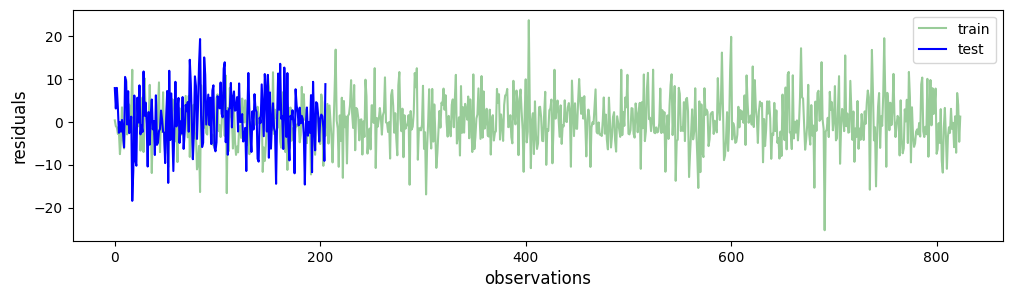

In [62]:
# visually check independence of residuals
plt.figure(figsize=(12,3))
plt.plot(y_st_train-plr_model.predict(X_poly_train),c='g',alpha=0.4) # residual calculated using the training dataset
plt.plot(y_st_test-plr_model.predict(X_poly_test),c='b') # residual calculated using the testing dataset
plt.xlabel('observations',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.legend(['train','test'])
plt.show()

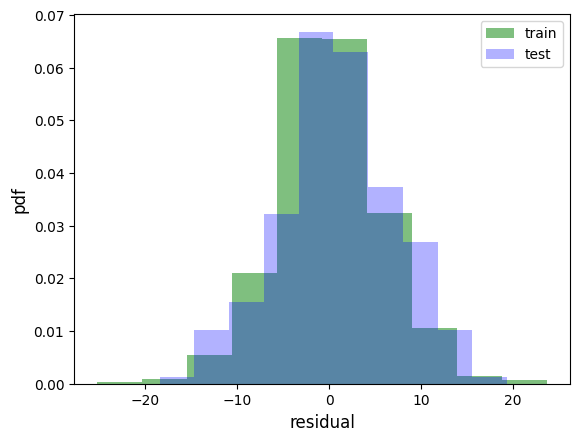

In [63]:
# examine the distribution of residuals
plt.hist(y_st_train-plr_model.predict(X_poly_train),density=True,color='g',alpha=0.5) # distribution of residuals - training dataset
plt.hist(y_st_test-plr_model.predict(X_poly_test),density=True,color='b',alpha=0.3) # distribuition of residuals - testing dataset
plt.legend(['train','test'])
plt.xlabel('residual',fontsize=12)
plt.ylabel('pdf',fontsize=12)
plt.show()

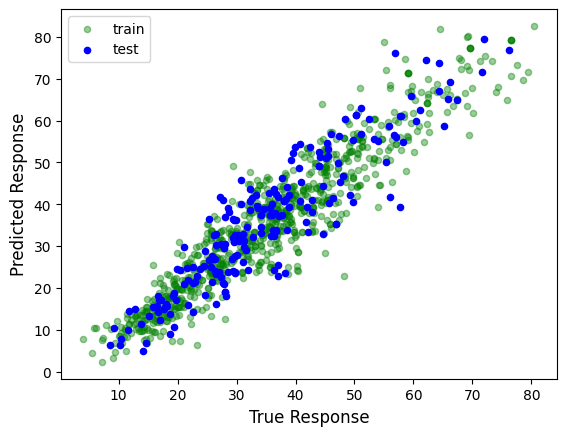

In [64]:
# show the correlation between predicted response and true response
plt.scatter(plr_model.predict(X_poly_train),y_st_train,c='g',s=20,alpha=0.4) # true vs. prediction - training dataset
plt.scatter(plr_model.predict(X_poly_test),y_st_test,c='b',s=20) # # true vs. prediction - testing dataset
plt.xlabel('True Response',fontsize=12)
plt.ylabel('Predicted Response',fontsize=12)
plt.legend(['train','test'])
plt.show()

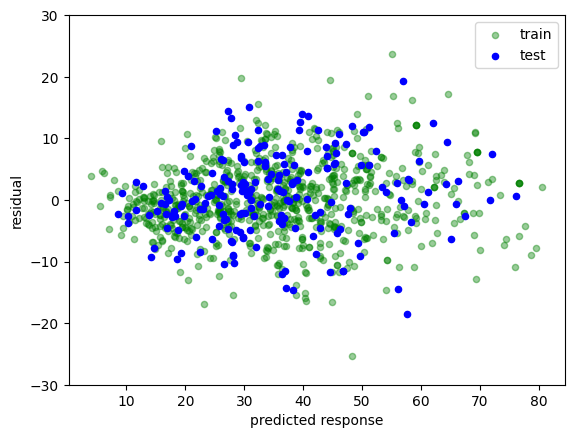

In [65]:
# residual against predicted response to check the homogeneity of residuals
plt.scatter(plr_model.predict(X_poly_train), y_st_train-plr_model.predict(X_poly_train),c='g',s=20,alpha=0.4)  # residual vs. prediction - training dataset
plt.scatter(plr_model.predict(X_poly_test), y_st_test-plr_model.predict(X_poly_test),c='b',s=20) # residual vs. prediction -testing dataset
plt.ylim([-30,30])
plt.legend(['train','test'])
plt.xlabel('predicted response')
plt.ylabel('residual')
plt.show()

# Binary Logistic Regression

We fit a binary logistic regression to predict if a concrete block will develop defect after one year of use by using the extracted PCs as the predictors

In [66]:
# let's check if classes are unbalanced. If it is unbalanced, we may consider
# using class weights in defining the loss function
uniqueVals, counts = np.unique(y_dft_train,return_counts=True)
print(f'The sizes for the classes {uniqueVals} are:\n')
print(counts)

The sizes for the classes [0. 1.] are:

[590 234]


In [67]:
# fit a logistic regression model
blr=LogisticRegression(multi_class='multinomial',class_weight={0:1,1:1.5},solver='sag') # if use cross-entropy loss, multi-class='multinomial'
#logr=LogisticRegression(multi_class='ovr') # if use one-vs-rest loss, multi-class='ovr'
blr_model=blr.fit(X_st_train,y_dft_train)


In [68]:
# regression coefficients
coeff_blr = pd.DataFrame(np.append(blr_model.intercept_,blr_model.coef_), ['1','x1','x2','x3','x4','x5','x6','x7','x8'], columns=['Coefficient'])
coeff_blr.round(4)

,Coefficient
1,-1.9315
x1,-0.9266
x2,-0.2590
x3,-0.9777
x4,-1.9129
x5,-0.9379
x6,-2.7296
x7,-0.8330
x8,-1.3012


In [69]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(blr_model, X_st_train, y_dft_train, cv =5, scoring = 'accuracy').mean()
print(f'the average accuracy is {r2_train*100 :.2f}%')

the average accuracy is 89.68%


In [70]:
# testing accuracy
blr_model.score(X_st_test,y_dft_test).round(3)

0.888

In [71]:
# prediction on training dataset
y_train_pred = blr_model.predict(X_st_train)
p_train_pred = blr_model.predict_proba(X_st_train)

In [72]:
# prediction on testing dataset
y_test_pred = blr_model.predict(X_st_test) #prediction of y_i's
p_test_pred = blr_model.predict_proba(X_st_test) # the probabilities that y_i is classes 0 and 1, respectively

# p_i=[p_i,0, p_i,1] # y_test_pred[i]=0 if p_i,0>p_i,1, otherwise y_test_pred[i]=1
#print(p_test_pred.round(2))

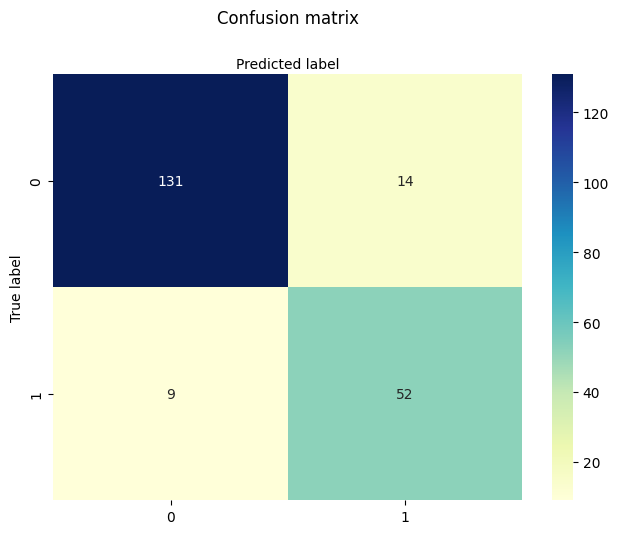

In [73]:
# confusion matrix
cnf_matrix=metrics.confusion_matrix(y_dft_test, y_test_pred)

# visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels=class_names,yticklabels=class_names)


ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Multinomial Logistic Regression

In [74]:
digits = datasets.load_digits() #load data
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [75]:
X, y = digits.data, digits.target #digits.data are predictors, digits.target is the response with 10 class (0,1,...,9)

# Parameters
dim = len(X[0]) # number of observations
print('The number of predictors is:', dim,'\n')
n_classes = len(np.unique(y)) # number of classes
print('The number of classes is:',n_classes,'\n')
obs = len(y)
print('The number of observations is:',obs, '\n')

random_state = 4 # to make the result replicable


X_norm = StandardScaler().fit_transform(X) # data normalization

# Split data (both features X and target y) into training and testing datasets.
# We use training data to learn model parameters.
# We use test data to assess the performance of prediction
X_train, X_test, y_train, y_test = train_test_split(
                                                    X_norm, y, test_size=0.2, stratify=y,
                                                    random_state=random_state)


The number of predictors is: 64 

The number of classes is: 10 

The number of observations is: 1797 



In [76]:
# fit a multnomial logistic regression
mlr=LogisticRegression(multi_class='multinomial',solver='saga',penalty='elasticnet', l1_ratio=0.3, max_iter=2000)
mlr_model = mlr.fit(X_train,y_train)


In [77]:
# point estimates of regression coefficients
coeff_mlr = pd.DataFrame(np.insert(mlr_model.coef_.T,0,mlr_model.intercept_,axis=0), columns=['0','1','2','3','4','5','6','7','8','9'])
#coeff_mlr = pd.DataFrame(np.append(mlr_model.intercept_,mlr_model.coef_), columns=['Coefficient'])
print('regresion coeffiients are:\n',coeff_mlr.round(4),'\n')

print('The number of zero-valued coefficients is:', (dim+1)*n_classes-np.count_nonzero(coeff_mlr))

regresion coeffiients are:
          0       1       2       3       4       5       6       7       8  \
0  -0.1878 -0.5032 -0.2579  0.0621 -0.3266  0.2940 -0.3045  0.0368  1.4093   
1   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2   0.0000  0.0000  0.0000  0.1284 -0.0956  0.2933  0.0000  0.0000 -0.1044   
3   0.0000  0.0000  0.0495 -0.1764 -0.4169  1.0661 -0.2934  0.2398  0.0582   
4   0.0000  0.2093  0.0531  0.0571 -0.9209 -0.2415 -0.1391  0.0606 -0.1532   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
60  0.1810 -0.1215  0.2099  0.1196 -0.5491  0.6822 -0.2947 -0.4768  0.1811   
61  0.0000  0.3231  0.0319  0.0000 -0.3668 -0.0070  0.0000 -0.8753  0.4901   
62 -0.0754  0.6615  0.6555  0.0000 -0.5207  0.0000  0.6584 -0.8254 -0.2671   
63 -0.0566  0.3064  0.6570  0.0220 -0.0544 -0.6653  0.0475 -0.1184 -0.1536   
64  0.0000  0.4134  0.3956 -0.1545  0.0000 -0.0390 -0.0837  0.0000  0.0000   

         9  
0  -0.2222  
1   0.000

In [78]:
# evaluate the goodness-of-fit of the regression model in training using cross-validation
r2_train = cross_val_score(mlr_model, X_train, y_train, cv =5, scoring = 'accuracy').mean()
print(f'the average accuracy is {r2_train*100 :.2f}%')

the average accuracy is 96.66%


In [79]:
# test accuracy
mlr_model.score(X_test,y_test).round(3)

0.981

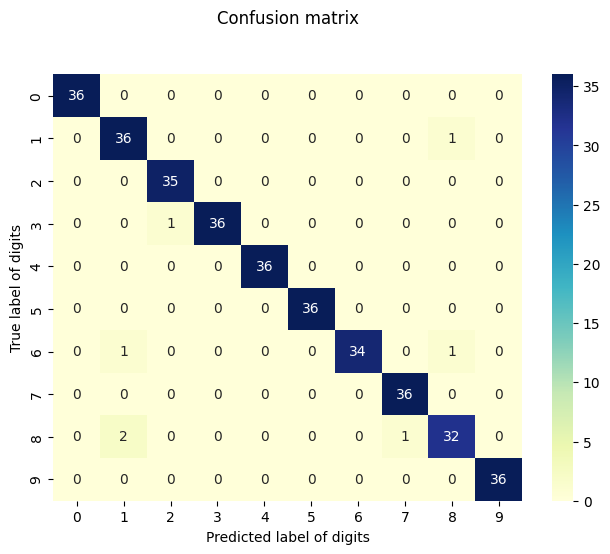

In [80]:
# confusion matrix
cnf_matrix=metrics.confusion_matrix(y_test, mlr_model.predict(X_test))
# visualize confusion matrix
class_names=[0,1,2,3,4,5,6,7,8,9] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels=class_names,yticklabels=class_names)


ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label of digits')
plt.xlabel('Predicted label of digits')
plt.show()

# Ordinal Logistic Regression

## Diamonds dataset

The Diamond.csv dataset we use here is a revision of the dataset diamonds.csv from Kaggle. It contains the prices and other attributes of almost 54,000 diamonds.

Attributes
carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

price: price in US dollars (\$326--\$18,823)

volume: x*y*z mm^3 (0--20116.23)

In [81]:
#Load data
Diamond = pd.read_csv('Data/Diamond.csv')
Diamond.head()

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.20
1,0.21,Premium,E,SI1,59.8,61.0,326,34.51
2,0.23,Good,E,VS1,56.9,65.0,327,38.08
3,0.29,Premium,I,VS2,62.4,58.0,334,46.72
4,0.31,Good,J,SI2,63.3,58.0,335,51.92


In [82]:
# Check the data type of the dataset
Diamond.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   volume   53940 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.3+ MB


In [83]:
# statsmodels requires that the response is a categorical variable with ordered classes.
# Therefore, we define the response as an ordered categorical variable
cat_type = pd.CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)
Diamond['cut'] = Diamond['cut'].astype(cat_type)
Diamond['cut'].dtype

CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True, categories_dtype=object)

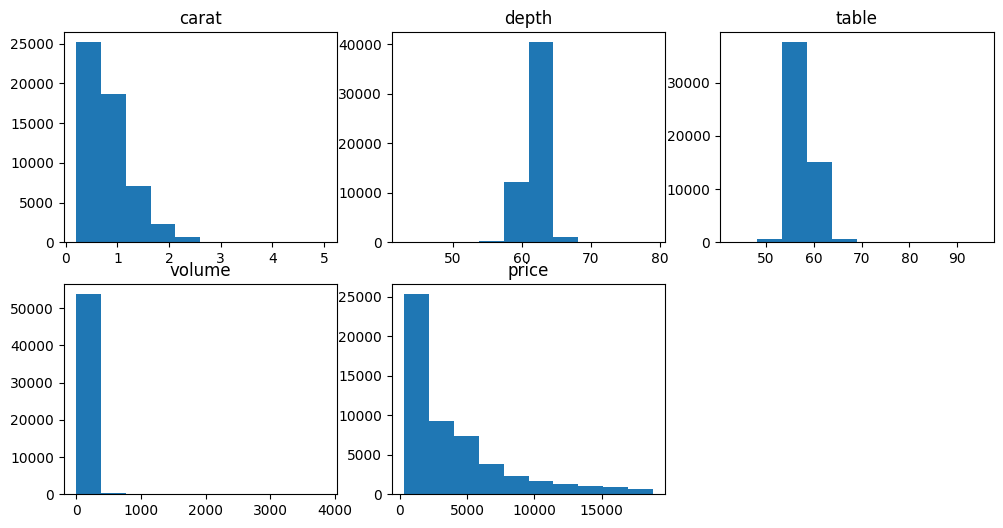

In [84]:
# show the histogram of numerical predictors
# several of them are not normally distributed and their scales are quite different.
# we may normalize these predicdtors

plt.figure(figsize=(12, 6))

plt.subplot(2,3,1)
plt.hist(Diamond.carat)
plt.title('carat')

plt.subplot(2,3,2)
plt.hist(Diamond.depth)
plt.title('depth')

plt.subplot(2,3,3)
plt.hist(Diamond.table)
plt.title('table')

plt.subplot(2,3,4)
plt.hist(Diamond.volume)
plt.title('volume')

plt.subplot(2,3,5)
plt.hist(Diamond.price)
plt.title('price')

plt.show()

In [85]:
# show the frequency distributions of categorical predictors and the response as well
# If categorical variables are used as predictors, we may recode them as dummy variables
print(Diamond[['cut']].value_counts(),'\n')
print(Diamond[['color']].value_counts(),'\n')
print(Diamond[['clarity']].value_counts())

cut      
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64 

color
G        11292
E         9797
F         9542
H         8304
D         6775
I         5422
J         2808
Name: count, dtype: int64 

clarity
SI1        13065
VS2        12258
SI2         9194
VS1         8171
VVS2        5066
VVS1        3655
IF          1790
I1           741
Name: count, dtype: int64


In [86]:
# normalize the quantitative predictors
temp=StandardScaler().fit_transform(Diamond[['carat','depth','table','price','volume']])
Diamond=pd.concat([pd.DataFrame(temp,columns=['carat','depth','table','price','volume']),Diamond[['cut','color','clarity']]],axis=1)
Diamond.head()

,carat,depth,table,price,volume,cut,color,clarity
0,-1.198168,-0.174092,-1.099672,-0.904095,-1.171321,Ideal,E,SI2
1,-1.240361,-1.360738,1.585529,-0.904095,-1.218480,Premium,E,SI1
2,-1.198168,-3.385019,3.375663,-0.903844,-1.172854,Good,E,VS1
3,-1.071587,0.454133,0.242928,-0.902090,-1.062431,Premium,I,VS2
4,-1.029394,1.082358,0.242928,-0.901839,-0.995973,Good,J,SI2


In [87]:
# code categorical predictors as dummy variables
Diamond = pd.get_dummies(Diamond, columns=['color','clarity'],dtype=float)
Diamond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   carat         53940 non-null  float64 
 1   depth         53940 non-null  float64 
 2   table         53940 non-null  float64 
 3   price         53940 non-null  float64 
 4   volume        53940 non-null  float64 
 5   cut           53940 non-null  category
 6   color_D       53940 non-null  float64 
 7   color_E       53940 non-null  float64 
 8   color_F       53940 non-null  float64 
 9   color_G       53940 non-null  float64 
 10  color_H       53940 non-null  float64 
 11  color_I       53940 non-null  float64 
 12  color_J       53940 non-null  float64 
 13  clarity_I1    53940 non-null  float64 
 14  clarity_IF    53940 non-null  float64 
 15  clarity_SI1   53940 non-null  float64 
 16  clarity_SI2   53940 non-null  float64 
 17  clarity_VS1   53940 non-null  float64 
 18  clarit

## Fitting an Ordinal Logistic Regression Model

In [88]:
# our hypothesis is that the cut can be inferred from the physical features of
# diamonds, including carat, table, depth, and volume
X =Diamond[['carat','table','depth','volume']]
y = Diamond['cut']
random_state = 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state)

In [89]:
# statsmodels requires that the response is an ordered categorical variable
# we change the response in the training dataset accordingly
#cat_type = pd.CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)
#y_train = y_train.astype(cat_type)
#y_train.dtype

In [90]:
ordlr_model = OrderedModel(y_train,X_train,distr='logit')
result_ordlr = ordlr_model.fit(method='bfgs')
result_ordlr.summary()

Optimization terminated successfully.
         Current function value: 1.167117
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    cut   Log-Likelihood:                -50363.
Model:                   OrderedModel   AIC:                         1.007e+05
Method:            Maximum Likelihood   BIC:                         1.008e+05
Date:                Wed, 02 Oct 2024                                         
Time:                        19:00:00                                         
No. Observations:               43152                                         
Df Residuals:                   43144                                         
Df Model:                           4                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
carat                -0.4007      0.114     -3.513      0.000      -0.624      -0.177
table                -1.3351      0.012   -111.965      0.000      -1.358      -1.312
depth                -0.8960      0.012    -75.184      0.000      -0.919      -0.873
volume                0.3414      0.116      2.935      0.003       0.113       0.569
Fair/Good            -4.4689      0.033   -133.768      0.000      -4.534      -4.403
Good/Very Good        0.6294      0.016     39.705      0.000       0.598       0.660
Very Good/Premium     0.5170      0.010     53.887      0.000       0.498       0.536
Premium/Ideal         0.3441      0.009     39.562      0.000       0.327       0.361
=====================================================================================
"""

In [91]:
# the estimates of p_{i,k} = p(y_i=class k|x_i, hat_w, beta_k)
p = result_ordlr.model.predict(result_ordlr.params, X_test)
p

array([[0.02256752, 0.10845957, 0.31546436, 0.32129112, 0.23221742],
       [0.00650932, 0.0345237 , 0.14523742, 0.29780019, 0.51592936],
       [0.00296401, 0.01608078, 0.07504571, 0.20450542, 0.70140409],
       ...,
       [0.1421426 , 0.37757279, 0.33298674, 0.10685738, 0.04044049],
       [0.03204848, 0.14573715, 0.35855723, 0.28948147, 0.17417567],
       [0.01329658, 0.06759066, 0.23921504, 0.33857102, 0.3413267 ]])

In [92]:
# the estimates of y_i = argmax_k (y_{i,1},..., y_{i,k},..., y_{i,K})
# that is the class with the higheset probability is the prediction for y_i
y_test_pred=p.argmax(1)
y_test_pred

array([3, 4, 4, ..., 1, 2, 4])

In [93]:
# We convert the ordered categories of the ground truth into numbers
# In this way, the ground truth y_test and the prediction y_test_pred are in the same data type
# This makes the following evaluation easier
mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
y_test_num = np.vectorize(mapping.get)(y_test)

In [94]:
# Let's take a look at the counts by class in y_test and y_test_pred
class_names=['Fair', 'Good', 'Very Good', 'Premium','Ideal']

unique_values, counts = np.unique(y_test_num, return_counts=True)
print(f'The true volumes of class {class_names} are')
print(counts,'\n')

unique_values, counts = np.unique(y_test_pred, return_counts=True)
print(f'The predicted volumes of class {class_names} are')
print(counts)

The true volumes of class ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] are
[ 322  981 2417 2758 4310] 

The predicted volumes of class ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] are
[  95  390 2543 1409 6351]


## Evaluation

In [95]:
# calcualte accuracy
acc = np.sum(y_test_num==y_test_pred)/len(y_test_num)
acc.round(2)

0.53

<Figure size 640x480 with 0 Axes>

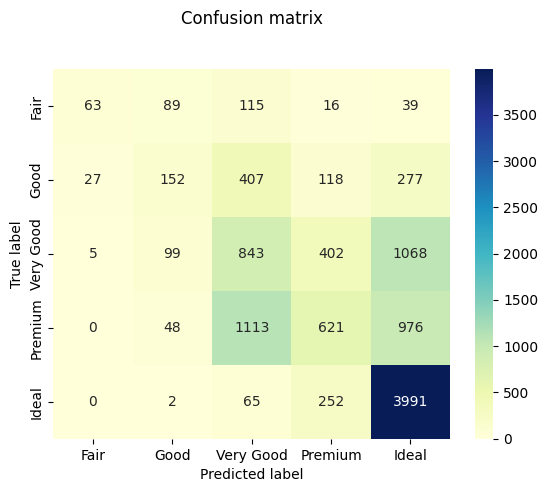

In [96]:
# confusion matrix
cnf_matrix=metrics.confusion_matrix(y_test_num, y_test_pred)

# visualize confusion matrix
plt.tight_layout()
fig, ax = plt.subplots()
class_names=['Fair', 'Good', 'Very Good', 'Premium','Ideal'] # name  of classes
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',ax=ax,xticklabels=class_names, yticklabels=class_names)
tick_marks = np.arange(len(class_names))
ax.xaxis.set_label_position("bottom")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()